In [4]:
import itertools
from copy import deepcopy as copy
from scipy.linalg import fractional_matrix_power, block_diag
import networkx as nx
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy 
from numpy.linalg import matrix_rank as rank 
from Adversary import Problem, to_str, visualize, Adversary, hamming_dist as dist
from Solvers import type_mask, partial, ket, instance_mask, adv_solver
from ElementDistinctness import ED
from Examples import exact_k, threshold_k
from time import time
mpl.rcParams["figure.dpi"] = 120 

In [5]:
def get_oracles(funcs, oracle_getter):
    print('get_oracles', len(funcs))
    return {func: oracle_getter(func) for func in funcs}

def get_phase_oracles(problem):
    oracles = {}
    # roots = nthRootsOfUnity(n)
    if isinstance(problem, Problem):
        instances = problem.instances
    n = len(instances[0])
    for instance in instances:
        oracle = np.zeros((n,n))
        for i in range(n):
            oracle[i, i] =-1 if instance[i] == 1 else 1
        oracles[instance] = oracle
        
    return oracles
def phase_oracle(func):
    oracle = np.zeros((len(func),len(func)))
    for i in range(len(func)):
        oracle[i,i] = 1 if func[i] == 0 else -1
    return oracle 
def get_standard_oracles(problem):
    oracles = {}
    n = problem.n
    alpha_len = len(problem.alphabet)
    for instance in problem.instances:
        oracle = []
        for i in range(n):
            curr_oracle = np.zeros((alpha_len, alpha_len))
            for a in problem.alphabet:
                curr_oracle[a, (instance[i] + a) % alpha_len] = 1
            # print(curr_oracle)
            oracle.append(copy(curr_oracle))
        oracles[instance] = block_diag(*oracle)
        # print(oracles[instance])
    return oracles
def standard_oracle(func, alpha_len=None):
    n = len(func)
    if alpha_len is None:
        alpha_len = n
    oracle = []
    for i in range(n):
        curr_oracle = np.zeros((alpha_len, alpha_len))
        for a in range(alpha_len):
            curr_oracle[a, (func[i] + a) % alpha_len] = 1
            # print(curr_oracle)
        oracle.append(copy(curr_oracle))
    return block_diag(*oracle)

def get_oracle_diffs(oracles, prod=True, mat=False, keys=None):
    oracle_diffs = {} 
    if keys is None:
        keys = list(oracles.keys())
    # keys.sort()
    for v1 in keys:
        for v2 in keys:
            if prod:
                oracle_diffs[(v1, v2)] = np.eye(oracles[v1].shape[0])- oracles[v1].T @ oracles[v2]
            else:
                # print('normal diff')
                oracle_diffs[(v1, v2)] = oracles[v1] - oracles[v2]
    if mat:
        oracle_diffs =  [
            [
                oracle_diffs[(k1, k2)] for k1 in keys
            ] for k2 in keys
        ]
    return oracle_diffs
def permutation_oracle(perm):
    n = len(perm)
    oracle = np.zeros((n, n))
    for i in range(n):
        oracle[i, perm[i]] = 1
    return oracle

def get_permutation_oracles(instances):
    # assuming instances are all lists representing permutations
    oracles = {}
    n = len(instances[0])
    print(n)
    # assert tuple(range(n)) == problem.alphabet
    for instance in instances:
        oracle = np.zeros((n, n))
        for i in range(n):
            oracle[i, instance[i]] = 1
        oracles[instance] = oracle
        # assert oracle@oracle.T - np.eye(n)
    return oracles

def preimage_even_odd(n):
    perms = itertools.permutations(range(n))
    no_instances = []
    yes_instances = []
    for perm in get_cycles(n,n):
        # print(to_str(perm))
        if perm.index(0) >= n//2:
            yes_instances.append(perm)
        else:
            no_instances.append(perm)
    return Problem(no_instances, yes_instances)

In [41]:
def get_cycles(n, k):
    perm = tuple(range(n))
    yes_instances = set()
    for cycle_points in itertools.permutations(perm, k):
        curr_cycle = list(perm)
        for i in range(k-1):
            curr_cycle[cycle_points[i]] = cycle_points[i+1]
        curr_cycle[cycle_points[-1]] = cycle_points[0]
        yes_instances.add(tuple(curr_cycle))
    return list(yes_instances)
def num_fixed_points(perm):
    curr_sum = 0
    for i in range(len(perm)):
        if perm[i] == i:
            curr_sum += 1
    return curr_sum

def permutation_thresh(n, k):
    # perm = nkp.array(range(n))
    no_instances = set()
    yes_instances = set()
    for perm in itertools.permutations(tuple(range(n))):
        num_fixed = num_fixed_points(perm)
        if num_fixed == k:
            no_instances.add(perm)
        elif num_fixed == k + 1:
            yes_instances.add(perm)
    return Problem(list(no_instances), list(yes_instances))
def equality(n):
    perms = list(itertools.permutations(list(range(n))))
    no_instances = []
    yes_instances = [tuple(perm + tuple(p + n for p in perm)) for perm in perms]
    for perm1, perm2 in itertools.combinations_with_replacement(perms, 2):
        instance = tuple(perm1+ tuple(p + n for p in perm2))
        if dist(perm1, perm2) == 2:
            no_instances.append(instance)
    return Problem(no_instances, yes_instances)


def fixed_points(n, k):
    no_instances = []
    yes_instances = []
    for perm in itertools.permutations(range(n)):
        fp = num_fixed_points(perm)
        if fp == k:
            no_instances.append(perm)
        elif fp == k+1:
            yes_instances.append(perm)
    return Problem(no_instances, yes_instances)
        
def cycle0(n, k):
    no_instances = [cycle for cycle in get_cycles(n, k) if cycle[0] != 0]
    yes_instances = [cycle for cycle in get_cycles(n, k+1) if cycle[0] != 0]
    return Problem(no_instances, yes_instances)
def cycle(n, k, k2=None):
    if k2 is None:
        k2 = k+1
    no_instances = get_cycles(n,k)
    yes_instances = get_cycles(n, k2)
    return Problem(no_instances, yes_instances)

def preimage(n, k):
    # perms = list(itertools.permutations(range(n)))
    no_instances = []
    yes_instances = []
    for perm in get_cycles(n, k):
        preimage0 = perm.index(0)
        # print(preimage0, perm)
        if preimage0 % 2:
            yes_instances.append(perm)
        else:
            no_instances.append(perm)
    # print(no_instances)
    # print(yes_instances)
    return Problem(no_instances, yes_instances)
def get_all_cycles(perm):
    cycles =[]
    points_in_cycles = set()
    for i in range(n):
        if i not in points_in_cycles and perm[i] != i:
            cycle = [i]
            j = perm[i]
            points_in_cycles.add(j)
            while j not in cycle:
                cycle.append(j)
                j = perm[j]
                points_in_cycles.add(j)
            cycles.append(tuple(cycle))
    return cycles

def num_cycles(perm):
    return len(get_all_cycles(perm))
        
def transpose_thresh(n, k):
    perms = itertools.permutations(range(n))
    no_instances = []
    yes_instances = []
    for perm in perms:
        cycles = get_all_cycles(perm)
        cycle_lengths = set(len(cycle)  for cycle in cycles)
        if cycle_lengths == set([2]):
            if len(cycles) == k:
                no_instances.append(perm)
            elif len(cycles) == k+1:
                yes_instances.append(perm)
    return Problem(no_instances, yes_instances)

def transpose(n, easy=False):
    perm = tuple(range(n))
    no_instances = []
    if easy:
        for i in range(n//2):
            instance = list(perm)
            instance[2*i] = 2*i + 1
            instance[2*i+1] = 2*i
            no_instances.append(tuple(instance))
    else:
        for i,j in itertools.combinations(perm, 2):
            # print(i,j)
            instance = list(perm)
            instance[i] = j
            instance[j] = i
            no_instances.append(tuple(instance))
    return Problem([perm], list(no_instances))

def relative_hadamard_norm_min(mat, relative, D1_len):
    mat_len = mat.shape[0]
    mat_size = mat_len
    D1 = list(range(D1_len))
    D2 = list(range(D1_len, mat_size))
    relative_shape = relative[0][0].shape
    t = cp.Variable(nonneg=True)
    X = [[cp.Variable(relative_shape) for _ in range(mat_len)] for _ in range(mat_len)]
    for x in D1:
        for y in D2:
            X[x][y] = cp.Variable(relative_shape)
    constraints = [cp.bmat(X) >> 0]
    constraints += [
        mat[x][y] == cp.trace(X[x][y].T @ relative[x][y]) 
        for x in range(mat_size) for y in range(mat_size)
    ]
    constraints += [
        t >= cp.trace(X[z][z]) for z in range(mat_size)
    ]
    
    opt_prob = cp.Problem(cp.Minimize(t), constraints)
    opt_prob.solve(verbose=True) 
    for x in range(mat_size):
        for y in range(mat_size):
            X[x][y] = X[x][y].value
    return X
    
def relative_hadamard_norm_max(mat, relative_mat, D1_len, solver="MOSEK"):
    print('shapes', )
    relative_shape = [0,0]
    relative_shape[0] = relative_mat.shape[0] // mat.shape[0]
    relative_shape[1] = relative_mat.shape[1] // mat.shape[1]
    relative_shape = tuple(relative_shape)
    D1 = list(range(mat.shape[0]))
    D2 = list(range((mat.shape[1]))) 
    
    # print(D1_len, len(D2), relative.shape)
    # relative_mat = np.block(relative)

    print(relative_mat.shape)
    mu = cp.Variable((len(D1)+len(D2)), nonneg=True)
    Lambda = cp.Variable((len(D1), len(D2)))
    print(relative_shape)
    Lambda_relative = cp.kron(Lambda, np.ones(relative_shape))
    Lambda_relative = cp.multiply(Lambda_relative, relative_mat)
    Lambda_square_relative = cp.bmat([
        [np.zeros((Lambda_relative.shape[0], Lambda_relative.shape[0])), -Lambda_relative
        ],
        [-Lambda_relative.T, np.zeros((Lambda_relative.shape[1], Lambda_relative.shape[1]))]
    ])
    diag = cp.kron(cp.diag(mu), np.eye(relative_shape[0]))
    # print(W.shape, diag.shape)
    W = Lambda_square_relative + diag
    # print(W)
    constraints = [cp.sum(mu) == 1, W >> 0]
    opt_prob = cp.Problem(cp.Maximize(2 * cp.sum(cp.multiply(Lambda.T, mat))), constraints)
    opt_prob.solve(verbose=True, solver=solver, mosek_params= {"MSK_IPAR_NUM_THREADS": 8}) 
    return Lambda.value, mu.value, W.value

def to_adversary_mat(Lambda, mu):
    G = np.zeros(Lambda.shape)
    for x in range(Lambda.shape[0]):
        for y in range(Lambda.shape[1]):
            G[x,y] = Lambda[x,y]/np.sqrt(mu[x] * mu[ y])
            
    return G

In [42]:
def search_perm_sorter(perms):
    n = len(perms[0])
    perm_types = {i:[] for i in range(n)}
    for perm in perms:
        perm_types[perm.index(0)].append( perm)
    for t in perm_types:
        perm_types[t].sort()
    perm_assignment = {}
    curr_perm = 0
    for i, permsi in perm_types.items():
        permsi = list(permsi)
        for perm in permsi:
            perm_assignment[perm] = curr_perm
            curr_perm += 1
    # print(perm_assignment)
    return perm_assignment, perm_types

def search_mask(funcs, assignment=None, marker=0):
    size = len(funcs)
    if assignment is None:
        assignment = search_perm_sorter(funcs)
    if assignment == 'same':
        assignment = {funcs[i]: i for i in range(len(funcs))}
    # print(size)
    mask = np.zeros((size, size))
    for f in funcs:
        f0 = f.index(marker)
        for g in funcs:
            g0 = g.index(marker)
            if f0 != g0:
                mask[assignment[f], assignment[g]] = 1
    return mask
def index_or(n):
    funcs = list(set(itertools.permutations([1] + [0] * (n-1))))
    funcs.sort()
    print(funcs)
    size = len(funcs)
    return funcs, search_mask(funcs, assignment='same', marker=1)
# print(index_or(n))

get_oracles 120
{(0, 1, 2, 3, 4): 0, (0, 1, 2, 4, 3): 1, (0, 1, 3, 2, 4): 2, (0, 1, 3, 4, 2): 3, (0, 1, 4, 2, 3): 4, (0, 1, 4, 3, 2): 5, (0, 2, 1, 3, 4): 6, (0, 2, 1, 4, 3): 7, (0, 2, 3, 1, 4): 8, (0, 2, 3, 4, 1): 9, (0, 2, 4, 1, 3): 10, (0, 2, 4, 3, 1): 11, (0, 3, 1, 2, 4): 12, (0, 3, 1, 4, 2): 13, (0, 3, 2, 1, 4): 14, (0, 3, 2, 4, 1): 15, (0, 3, 4, 1, 2): 16, (0, 3, 4, 2, 1): 17, (0, 4, 1, 2, 3): 18, (0, 4, 1, 3, 2): 19, (0, 4, 2, 1, 3): 20, (0, 4, 2, 3, 1): 21, (0, 4, 3, 1, 2): 22, (0, 4, 3, 2, 1): 23, (1, 0, 2, 3, 4): 24, (1, 0, 2, 4, 3): 25, (1, 0, 3, 2, 4): 26, (1, 0, 3, 4, 2): 27, (1, 0, 4, 2, 3): 28, (1, 0, 4, 3, 2): 29, (2, 0, 1, 3, 4): 30, (2, 0, 1, 4, 3): 31, (2, 0, 3, 1, 4): 32, (2, 0, 3, 4, 1): 33, (2, 0, 4, 1, 3): 34, (2, 0, 4, 3, 1): 35, (3, 0, 1, 2, 4): 36, (3, 0, 1, 4, 2): 37, (3, 0, 2, 1, 4): 38, (3, 0, 2, 4, 1): 39, (3, 0, 4, 1, 2): 40, (3, 0, 4, 2, 1): 41, (4, 0, 1, 2, 3): 42, (4, 0, 1, 3, 2): 43, (4, 0, 2, 1, 3): 44, (4, 0, 2, 3, 1): 45, (4, 0, 3, 1, 2): 46, (4, 0,

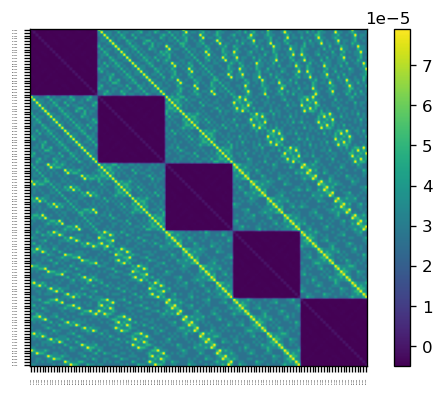

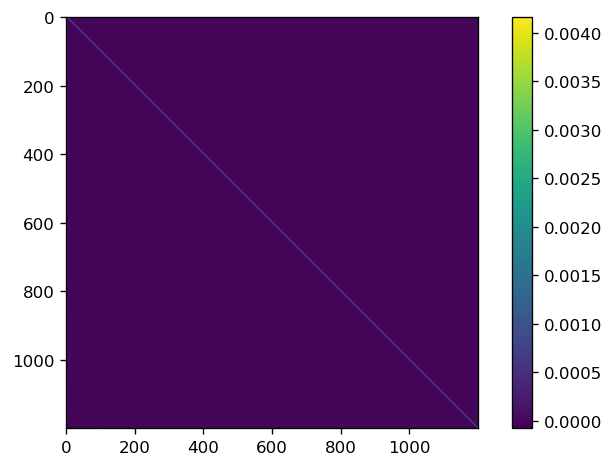

[0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.0041

In [50]:
n =5
k = 2

# perms, mat = index_or(n)
# perms = list(itertools.permutations)
# perms = [perm for perm in perms.instances if perm.index(0)!=0]


perms = list(itertools.permutations(range(n)))
# # perms = perms[:3] + perms[-2:]
keys, perm_types = search_perm_sorter(perms)
# # print(len(perms), len(keys))
oracles = get_oracles(perms, permutation_oracle)
# # print(len(oracles))
oracle_diffs_list = get_oracle_diffs(oracles, keys=keys, prod=True, mat=True)
print(keys)
# # print('blah', len(oracle_diffs_list), len(oracle_diffs_list[0]), oracle_diffs_list[0][0].shape)
# # print(oracle_diffs_list)
oracle_diffs = np.block(oracle_diffs_list)

# visualize(oracle_diffs)
mat = search_mask(perms, assignment=keys)
print('boop')
start = time()
Lambda, mu, W = relative_hadamard_norm_max(mat, oracle_diffs, len(perms), solver="MOSEK")
visualize(Lambda, (perms, perms), to_string=True)
visualize(W)
# visualize(W[] * oracle_diffs)
print(mu)
print("time",  time()-start)
print(set(np.round(W.flatten(), 7)))

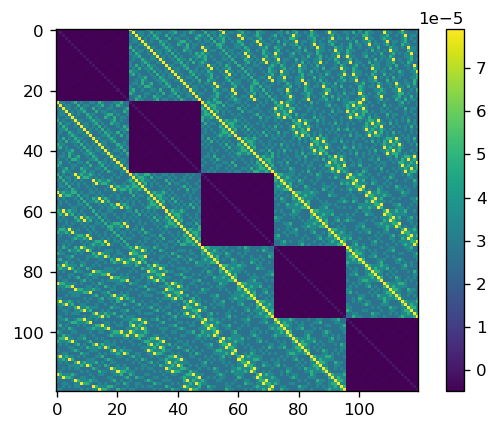

-4.921426700875976e-06
[0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667 0.00416667
 0.00416667 0.00416667 0.00416667 0.004

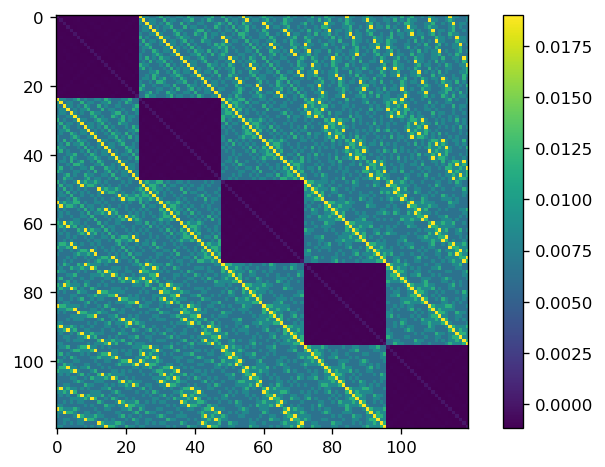

bigmat


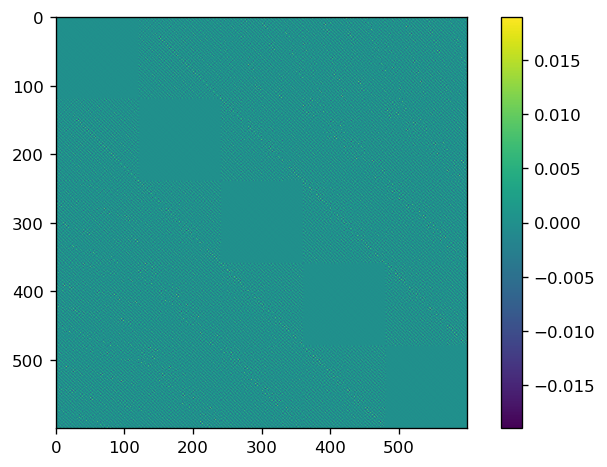

eig
1.000000154774583


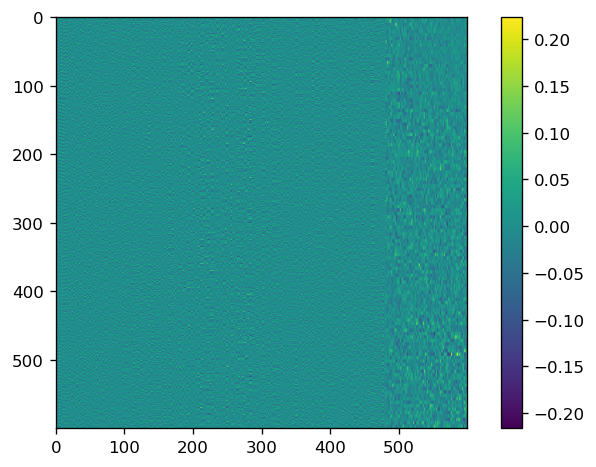

[ 0.08164966 -0.02041241 -0.02041241 -0.02041241 -0.02041241  0.08164966
 -0.02041241 -0.02041241 -0.02041241 -0.02041241  0.08164966 -0.02041241
 -0.02041241 -0.02041241 -0.02041241  0.08164966 -0.02041241 -0.02041241
 -0.02041241 -0.02041241  0.08164966 -0.02041241 -0.02041241 -0.02041241
 -0.02041241  0.08164966 -0.02041241 -0.02041241 -0.02041241 -0.02041241
  0.08164966 -0.02041241 -0.02041241 -0.02041241 -0.02041241  0.08164966
 -0.02041241 -0.02041241 -0.02041241 -0.02041241  0.08164966 -0.02041241
 -0.02041241 -0.02041241 -0.02041241  0.08164966 -0.02041241 -0.02041241
 -0.02041241 -0.02041241  0.08164966 -0.02041241 -0.02041241 -0.02041241
 -0.02041241  0.08164966 -0.02041241 -0.02041241 -0.02041241 -0.02041241
  0.08164966 -0.02041241 -0.02041241 -0.02041241 -0.02041241  0.08164966
 -0.02041241 -0.02041241 -0.02041241 -0.02041241  0.08164966 -0.02041241
 -0.02041241 -0.02041241 -0.02041241  0.08164966 -0.02041241 -0.02041241
 -0.02041241 -0.02041241  0.08164966 -0.02041241 -0

In [51]:
def to_str(L):
    return ''.join([str(x) for x in L])
    


plt.imshow(Lambda)
plt.colorbar()
plt.show()
print(np.min(Lambda))
print(mu)
# print(len(set(prob.yes_instances)))
# print(prob.yes_instances)
# print(Lambda.shape)

# print(2*np.sum(Lambda))
# print(Lambda[0,1])
# print(np.linalg.eig(G))
G = to_adversary_mat(Lambda, mu)
# plt.imshow(G)
# plt.colorbar()
# plt.show()
# print(mat)
t = .5
print('G', np.linalg.eigvals(G)[0])
print('Gmat', np.linalg.eigvals(G*mat)[0])
visualize(G)
big_mat = np.kron(G, np.ones((n ,n)))*oracle_diffs
# big_mat = t*np.eye(big_mat.shape[0]) + big_mat
print('bigmat')
visualize(big_mat)
print('eig')
print(np.max(np.real(np.linalg.eigvals(big_mat))))
visualize(np.real(np.linalg.eig(big_mat)[1]))
print((np.real(np.linalg.eig(big_mat)[1][:, 0])))
# print(Lambda.shape)
# A,_ = adv_solver(prob)

In [55]:
print(set(np.round(G.flatten(), 7)))

{0.0, -0.0009715, 0.0064192, 0.0083578, -0.0011811, 0.0064311, 0.0083639, 0.0117074, 0.0064208, -0.0010505, 0.0189822, -0.0010902}


In [47]:
print(G[0,1])

-0.007450912152840727


120 6
0 120.00000000000001


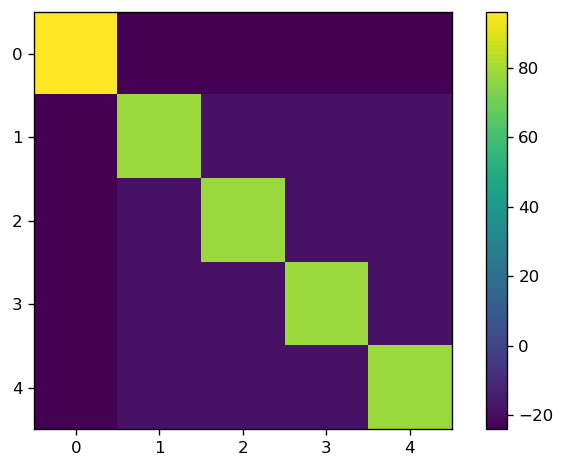

1 105.72299611087982


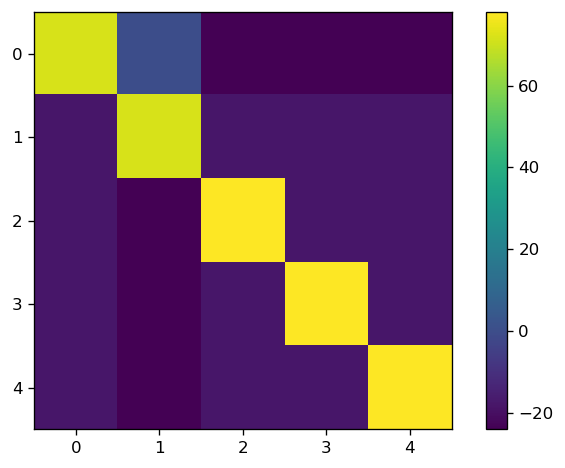

2 105.72299611087985


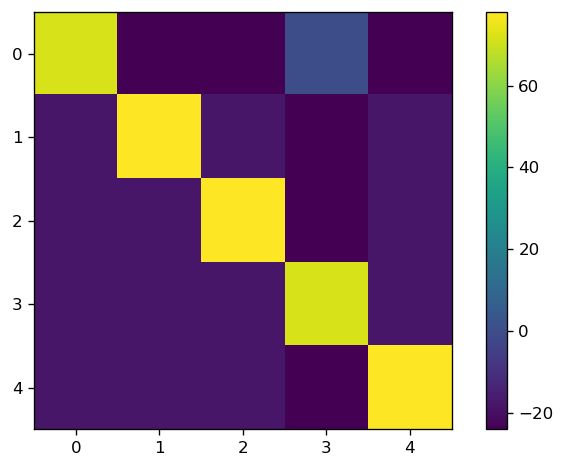

3 105.72299611087985


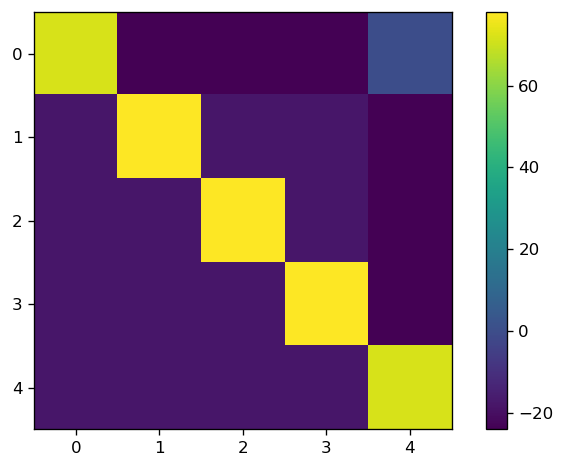

4 105.72299611087985


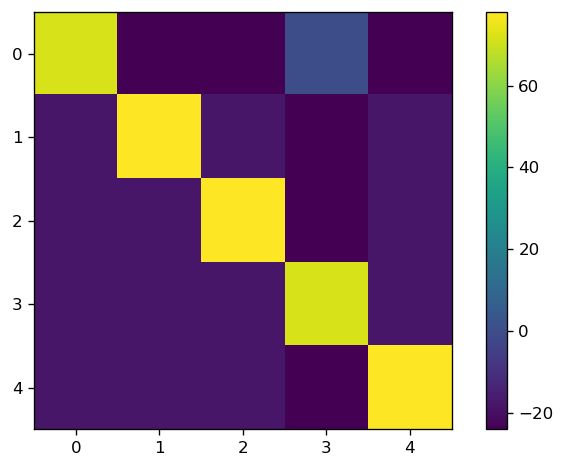

In [52]:
# print(oracle_diffs)
# print(oracle_diffs_list)
print(len(oracle_diffs_list), np.math.factorial(n-2))
fac = len(perm_types[0])
# print('fac', fac)
for j in range(n):
    curr_sum =  np.zeros((n, n))
    for i in list(range(0, j*fac)) + list(range((j+1)*fac, len(oracle_diffs_list))):
        curr_sum = curr_sum + oracle_diffs_list[j][i]
    print(j, np.linalg.norm(curr_sum, 2))
    visualize(curr_sum)

In [13]:
perm_mat = oracle_diffs * np.kron(mat, np.ones((n, n)))
cevals, cevects = np.linalg.eig(mat)
print((np.round(np.real(1/cevects[0,0]), 9)))
print(set(np.round(np.real(evects[:, 0]), 9)))
# visualize(perm_mat)
evals, evects = np.linalg.eig(perm_mat)
# visualize(np.real(evects))
# visualize(oracle_diffs)
print(evals[0], cevals[0])
visualize(np.real(cevects))


# print(evals[0])
# print(evects[0, :])

4.898979486


NameError: name 'evects' is not defined

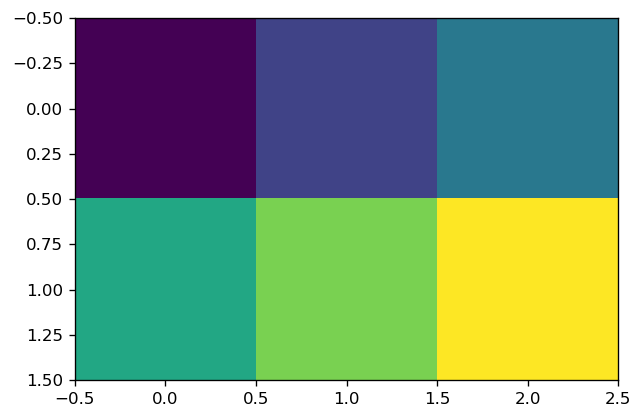

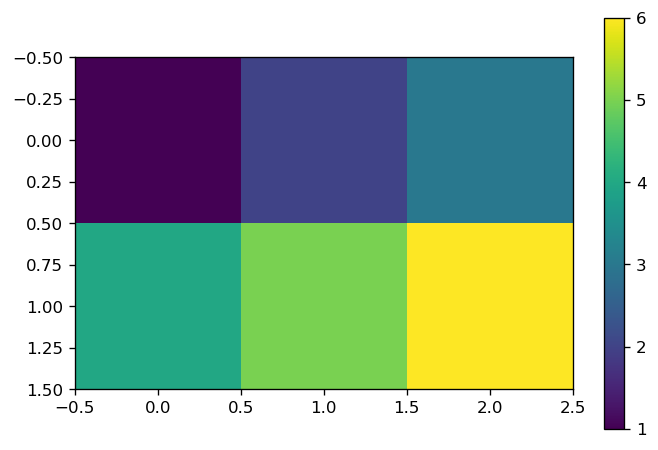

In [110]:
M = np.array([
[1,2,3],
[4,5,6]
])
plt.imshow(M)
plt.show()
visualize(M)

In [111]:
sym_perm_mat.eigenvals()

NameError: name 'sym_perm_mat' is not defined

In [112]:
M = Matrix([[1,0,0],[1,2,2], [3,2,1]])

NameError: name 'Matrix' is not defined

In [113]:
print(M)

[[1 2 3]
 [4 5 6]]


In [114]:
M.eigenvals()

AttributeError: 'numpy.ndarray' object has no attribute 'eigenvals'

In [115]:
perm_mat

array([[ 0.,  0.,  0., ...,  0.,  0., -1.],
       [ 0.,  0.,  0., ...,  0., -1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.]])

In [116]:
print(perm_types)

{0: [(0, 1, 2, 3, 4), (0, 1, 2, 4, 3), (0, 1, 3, 2, 4), (0, 1, 3, 4, 2), (0, 1, 4, 2, 3), (0, 1, 4, 3, 2), (0, 2, 1, 3, 4), (0, 2, 1, 4, 3), (0, 2, 3, 1, 4), (0, 2, 3, 4, 1), (0, 2, 4, 1, 3), (0, 2, 4, 3, 1), (0, 3, 1, 2, 4), (0, 3, 1, 4, 2), (0, 3, 2, 1, 4), (0, 3, 2, 4, 1), (0, 3, 4, 1, 2), (0, 3, 4, 2, 1), (0, 4, 1, 2, 3), (0, 4, 1, 3, 2), (0, 4, 2, 1, 3), (0, 4, 2, 3, 1), (0, 4, 3, 1, 2), (0, 4, 3, 2, 1)], 1: [(1, 0, 2, 3, 4), (1, 0, 2, 4, 3), (1, 0, 3, 2, 4), (1, 0, 3, 4, 2), (1, 0, 4, 2, 3), (1, 0, 4, 3, 2), (2, 0, 1, 3, 4), (2, 0, 1, 4, 3), (2, 0, 3, 1, 4), (2, 0, 3, 4, 1), (2, 0, 4, 1, 3), (2, 0, 4, 3, 1), (3, 0, 1, 2, 4), (3, 0, 1, 4, 2), (3, 0, 2, 1, 4), (3, 0, 2, 4, 1), (3, 0, 4, 1, 2), (3, 0, 4, 2, 1), (4, 0, 1, 2, 3), (4, 0, 1, 3, 2), (4, 0, 2, 1, 3), (4, 0, 2, 3, 1), (4, 0, 3, 1, 2), (4, 0, 3, 2, 1)], 2: [(1, 2, 0, 3, 4), (1, 2, 0, 4, 3), (1, 3, 0, 2, 4), (1, 3, 0, 4, 2), (1, 4, 0, 2, 3), (1, 4, 0, 3, 2), (2, 1, 0, 3, 4), (2, 1, 0, 4, 3), (2, 3, 0, 1, 4), (2, 3, 0, 4, 1),

In [10]:
global_perm_assignment = {}
count = 0
for t, ps in perm_types.items():
    for p in ps:
        global_perm_assignment[p] = count
        count += 1
# print(global_perm_assignment)

NameError: name 'perm_types' is not defined

In [ ]:
n =7
k = 2

# perms, mat = index_or(n)
# perms = list(itertools.permutations)
# perms = [perm for perm in perms.instances if perm.index(0)!=0]


perms = list(itertools.permutations(range(n)))
print('completed perms')
# # perms = perms[:3] + perms[-2:]
keys, perm_types = search_perm_sorter(perms)
print('perm types')
# # print(len(perms), len(keys))
oracles = get_oracles(perms, permutation_oracle)
print("oracles")
# # print(len(oracles))
oracle_diffs_list = get_oracle_diffs(oracles, keys=keys, prod=True, mat=True)
print("diff list")
# print(keys)
# # print('blah', len(oracle_diffs_list), len(oracle_diffs_list[0]), oracle_diffs_list[0][0].shape)
# # print(oracle_diffs_list)
oracle_diffs = np.block(oracle_diffs_list)
print("block")
# visualize(oracle_diffs)
mat = search_mask(perms, assignment=keys)
# print(mat)
diff_mat = oracle_diffs*np.kron(mat, np.ones((n,n)))

print(np.linalg.norm(diff_mat, 2), np.linalg.norm(oracle_diffs, 2), np.linalg.norm(np.ones(mat.shape), 2))

# visualize(diff_mat)
# visualize(oracle_diffs)

block_size = len(perm_types[1])
for i in range(n):
    for j in range(n):
        if i != j:
            starti = i * block_size * n
            endi = starti + block_size * n
            startj = j * block_size * n
            endj = startj + block_size *n
            curr_block = oracle_diffs[starti: endi, startj:endj]
            print(i,j, np.linalg.norm(curr_block, 2))
            # visualize(curr_block)
            

completed perms
perm types
get_oracles 5040
oracles
diff list
